In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os
import numpy as np
from irc.manager import AgentManager

rng = np.random.default_rng()

# Comparing distilled agent with individually trained ones

## Load agents

In [2]:
manager = AgentManager('store', defaults='irc-defaults.yaml')

min_epoch = 18
spec = 'cond-spec.yaml'
cond = manager._spec2cond(spec)
cond['seed'] = lambda x: x>=6 # agents are not used for training distilled agent
cond['task.ent_coef'] = lambda x: 0.02<x<0.04
keys = [key for key, _ in manager.completed(min_epoch=min_epoch, cond=cond)]

num_agents = 5
agents, configs = [], []
print(f'fetching {num_agents} out of {len(keys)} testing agents...')
for key in rng.choice(keys, size=num_agents, replace=False):
    config = manager.configs[key]
    print("env_param:\n("+', '.join(['{:.3g}'.format(x) for x in config.env_param])+")")
    print("gamma: {:.3g}, ent_coef: {:.3g}".format(config.task.gamma, config.task.ent_coef))
    _agent, _config = manager._fetch_agent_by_key(key)
    agents.append(_agent)
    configs.append(_config)

fetching 5 out of 54 testing agents...
env_param:
(1.32, 0.001, 0.1, 0, 0.0356, 0.2, 0.0519, 0.2, 0.0711, 0.2)
gamma: 0.988, ent_coef: 0.0333
env_param:
(0.149, 0.001, 0.1, 0, 0.0459, 0.2, 0.0682, 0.2, 0.0724, 0.2)
gamma: 0.869, ent_coef: 0.0315
env_param:
(0.0547, 0.001, 0.1, 0, 0.025, 0.2, 0.0535, 0.2, 0.0487, 0.2)
gamma: 0.897, ent_coef: 0.0337
env_param:
(0.338, 0.001, 0.1, 0, 0.0714, 0.2, 0.0304, 0.2, 0.03, 0.2)
gamma: 0.917, ent_coef: 0.0292
env_param:
(0.0219, 0.001, 0.1, 0, 0.0497, 0.2, 0.0301, 0.2, 0.0332, 0.2)
gamma: 0.835, ent_coef: 0.0386


In [3]:
import torch
from jarvis.config import Config
from irc.agent import DistilledBeliefAgent

saved = torch.load('store/wukong.pt')
agent = DistilledBeliefAgent(
    Config(saved['model_config']).instantiate(
        env=Config(saved['env_config']).instantiate(),
        init_net=saved['init_net'], update_net=saved['update_net'],
    ), saved['policy_net'],
)
agent.load_state_dict(saved['state_dict'])

In [4]:
# idx = rng.choice(num_agents)
idx = 0
config = configs[idx]
t_agent = agents[idx]
c_agents = [agents[i] for i in range(num_agents) if i!=idx]
agent.set_env_param(t_agent.model.get_param(), **config.task)
c_agents = [agent]+c_agents
print(f'Choose agent {idx} as the comparison target')

colors = plt.get_cmap('Set1').colors[:num_agents]

Choose agent 0 as the comparison target


## Compare state beliefs and action policies

In [5]:
def get_food_probs(agent, posgazes, beliefs):
    nvec = agent.model.env.state_space.nvec[2:]
    box_states = np.stack(np.unravel_index(np.arange(np.prod(nvec)), nvec)).T
    num_steps = beliefs.shape[0]-1
    
    probs = np.empty((num_steps+1, 8))
    for t in range(num_steps+1):
        states = np.concatenate([np.tile(posgazes[t], (len(box_states), 1)), box_states], axis=1)
        with torch.no_grad():
            logps = agent.model.p_s.loglikelihoods(
                agent.model._s_tensor(states), beliefs[t],
            )
        ps = logps.exp().numpy()
        for i in range(8):
            b0, b1, b2 = np.unravel_index(i, [2, 2, 2])
            probs[t, i] = ps[(states[:, 2]==b0)&(states[:, 4]==b1)&(states[:, 6]==b2)].sum()
    return probs

state_kls = [[] for _ in range(num_agents)]
action_kls = [[] for _ in range(num_agents)]

num_episodes = 50
for _ in range(num_episodes):
    with torch.no_grad():
        episode = t_agent.run_one_episode(max_steps=120)

    t_probs = get_food_probs(t_agent, episode.states[:, :2], episode.beliefs)
    c_probs = []
    for c_agent in c_agents:
        with torch.no_grad():
            beliefs, _ = c_agent.compute_likelihoods(episode.observations, episode.actions)
            c_probs.append(get_food_probs(c_agent, episode.states[:, :2], beliefs))

    for i in range(num_agents):
        state_kls[i].append((t_probs*(np.log(t_probs)-np.log(c_probs[i]))).sum(axis=1))
        
    t_probs = torch.softmax(episode.logits, dim=1).numpy()
    c_probs = []
    for c_agent in c_agents:
        with torch.no_grad():
            beliefs, _ = c_agent.compute_likelihoods(episode.observations, episode.actions)
            c_probs.append(torch.softmax(c_agent._get_distribution(beliefs[:-1]).logits, dim=1).numpy())

    for i in range(num_agents):
        action_kls[i].append((t_probs*(np.log(t_probs)-np.log(c_probs[i]))).sum(axis=1))

for i in range(num_agents):
    state_kls[i] = np.concatenate(state_kls[i])
    action_kls[i] = np.concatenate(action_kls[i])

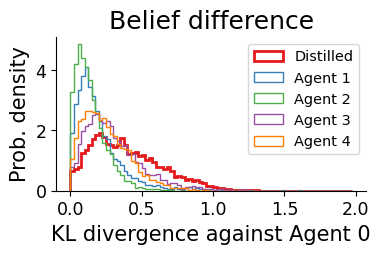

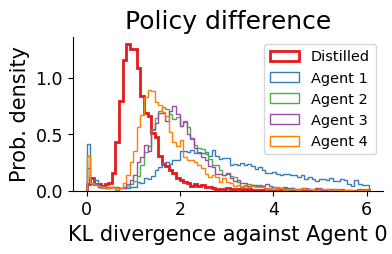

In [6]:
for k in range(2):
    if k==0:
        _vals = state_kls
        title = 'Belief difference'
        bins = np.linspace(0, 2+rng.normal()*0.05, 80)
    if k==1:
        _vals = action_kls
        title = 'Policy difference'
        bins = np.linspace(0, 6+rng.normal()*0.1, 80)
    _, ax = plt.subplots(figsize=(4, 2))
    for i in range(num_agents):
        ax.hist(_vals[i], bins, density=True, histtype='step', color=colors[i], linewidth=2 if i==0 else 1)
    ax.legend(['Distilled']+[f'Agent {i}' for i in range(num_agents) if i!=idx], fontsize='x-small')
    ax.set_xlabel(f'KL divergence against Agent {idx}')
    ax.set_ylabel('Prob. density')
    ax.set_title(title)
plt.show()

## Test performance

In [7]:
env = t_agent.model.env
gamma = config.task.gamma

num_episodes = 32
max_steps = 360

return_mean, return_std = {}, {}
for i in range(-1, num_agents):
    if i<0:
        _agent = t_agent
    else:
        _agent = c_agents[i]

    with torch.no_grad():
        episodes = _agent.run_episodes(num_episodes=num_episodes, max_steps=max_steps, env=env)
    returns = []
    for episode in episodes:
        returns.append([t_agent._return(gamma, episode.rewards[:t]) for t in range(episode.num_steps+1)])
    returns = np.stack(returns)
    return_mean[i] = np.mean(returns, axis=0)
    return_std[i] = np.std(returns, axis=0)

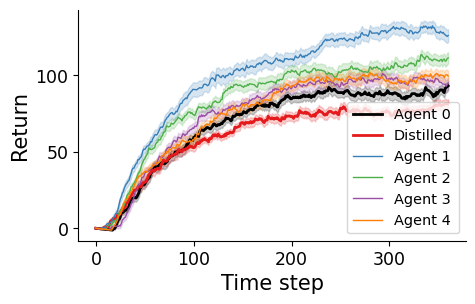

In [8]:
_, ax = plt.subplots(figsize=(5, 3))
h_lines = []
for i in range(-1, num_agents):
    if i<0:
        color = 'black'
    else:
        color = colors[i]
    
    v_mean = return_mean[i]
    v_sem = return_std[i]/num_episodes**0.5
    h_line, = ax.plot(np.arange(max_steps+1), v_mean, color=color, linewidth=2 if i<1 else 1)
    h_lines.append(h_line)
    ax.fill_between(
        np.arange(max_steps+1), v_mean-v_sem, v_mean+v_sem,
        color=color, alpha=0.2,
    )
ax.set_xlabel('Time step')
ax.set_ylabel('Return')
ax.legend(h_lines, [f'Agent {idx}', 'Distilled']+[f'Agent {i}' for i in range(num_agents) if i!=idx], fontsize='x-small')

plt.show()